In [97]:
import sys
sys.path.append('../')

In [98]:
%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params:

In [99]:
aggregate_by_state = False
evaluation_criteria = 'predict current day' #Out of ['hold out counties','predict current day']

## Basic Data Visualization

In [100]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(dir_mod = '../')
df = df.sort_values(load_data.outcome_deaths, ascending=False)
outcome_cases = load_data.outcome_cases # most recent day
outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)

In [101]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
1492


(array([56., 27., 25., 24., 18., 10.,  9.,  9.,  3.,  5., 12.,  6.,  4.,
         2.,  2.,  2.,  2.,  2.,  0.,  2.,  1.,  4.,  1.,  1.,  4.,  2.,
         0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 21.  ,  30.47,  39.94,  49.41,  58.88,  68.35,  77.82,  87.29,
         96.76, 106.23, 115.7 , 125.17, 134.64, 144.11, 153.58, 163.05,
        172.52, 181.99, 191.46, 200.93, 210.4 , 219.87, 229.34, 238.81,
        248.28, 257.75, 267.22, 276.69, 286.16, 295.63, 305.1 , 314.57,
        324.04, 333.51, 342.98, 352.45, 361.92, 371.39, 380.86, 390.33,
        399.8 , 409.27, 418.74, 428.21, 437.68, 447.15, 456.62, 466.09,
  

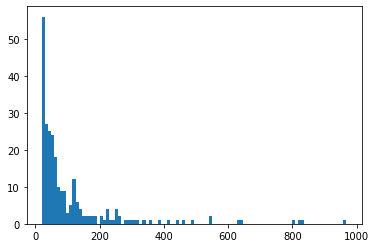

In [102]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [103]:
sum(max_cases)

64391

In [104]:
print(sum([v > 50 for v in max_cases]))


149


In [105]:
np.quantile(max_cases,.5)

3.0

Number of counties with non-zero deaths
228


(array([78.,  8.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  2.        ,  11.26666667,  20.53333333,  29.8       ,
         39.06666667,  48.33333333,  57.6       ,  66.86666667,
         76.13333333,  85.4       ,  94.66666667, 103.93333333,
        113.2       , 122.46666667, 131.73333333, 141.        ,
        150.26666667, 159.53333333, 168.8       , 178.06666667,
        187.33333333, 196.6       , 205.86666667, 215.13333333,
        224.4       , 233.66666667, 242.93333333, 252.2       ,
        261.46666667, 270.73333333, 280.        ]),
 <a list of 30 Patch objects>)

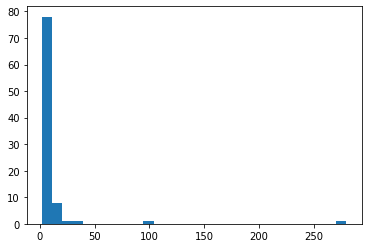

In [106]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

print('Number of counties with non-zero deaths')
print(sum([v >0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 1],bins=30)

In [107]:
sum(max_deaths)

945

In [108]:
max(max_deaths)

280

In [109]:
np.quantile(max_deaths,.5)

0.0

### Clean data

In [110]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
# df_with_cases = df[df['max_cases'] > 0]
df =  df[df['max_cases'] > 0]


In [111]:
if evaluation_criteria == 'hold out counties':
    # Randomly select counties for train/test split

    # Shuffle data
    shuffled_df = df_with_cases.sample(frac=1)
    # Break into train test (random k-fold cross val on the training set is done to pick hyperparams)
    train_ratio, val_ratio, test_ratio = .75,0,.25

    train_df = shuffled_df[0:int(train_ratio*len(shuffled_df))]
    test_df = shuffled_df[int(train_ratio*len(shuffled_df))+int(val_ratio*len(shuffled_df)):]
elif evaluation_criteria == 'predict current day':
    # Train df is all previous days
    # Test df is all days including current day
    previous_deaths = [d[:-1] for d in copy.deepcopy(df['deaths'])]
    previous_cases = [c[:-1] for c in copy.deepcopy(df['cases'])]
    train_df = copy.deepcopy(df)
    train_df['deaths'] = previous_deaths
    train_df['cases'] = previous_cases
    test_df = df
else:
    print('Unknown evaluation criteria')
    raise ValueError




## Predict data from model:

In [123]:
fit_and_predict(train_df, test_df, method='exponential')
fit_and_predict(train_df, test_df,'shared_exponential')
fit_and_predict(train_df, test_df, method='exponential',target_day = np.array([1,2]))
method_keys = [c for c in test_df if 'predicted' in c]

## Evaluate and visualize models

### Compute MSE and log MSE on relevant cases

In [124]:
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
number_of_deaths_threshold = 10

In [125]:
# Log scaled
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in test_df[key][outcome > number_of_deaths_threshold]]
    print('Log scale MSE for '+key)
    print(mse(np.log(outcome[outcome > number_of_deaths_threshold]),preds))

Log scale MSE for predicted_deaths_exponential_1
0.04152601682172378
Log scale MSE for predicted_deaths_exponential_2
0.10182649108792668
Log scale MSE for predicted_deaths_shared_exponential_1
0.06252252935098225


In [126]:
# No log scale
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in test_df[key][outcome > number_of_deaths_threshold]]
    print('Raw MSE for '+key)
    print(mse(outcome[outcome > number_of_deaths_threshold],preds))

Raw MSE for predicted_deaths_exponential_1
45.12518991510357
Raw MSE for predicted_deaths_exponential_2
2605.3435268187272
Raw MSE for predicted_deaths_shared_exponential_1
79.27611452618638


### Plot residuals

In [127]:
# TODO: Create bounds automatically

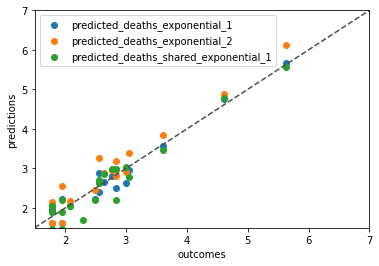

In [128]:
# Make log plots:
bounds = [1.5, 7]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in test_df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=key)
    
plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

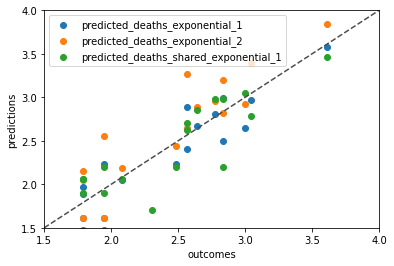

In [129]:
# Make log plots:
bounds = [1.5, 4]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in test_df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=key)

plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

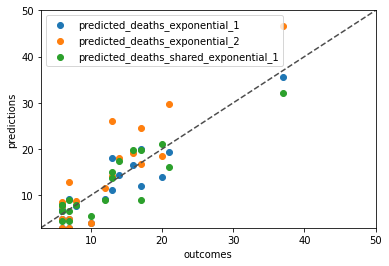

In [130]:
# Make non-log plots:
bounds = [3, 50]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in test_df[key][outcome > 5]]
    plt.scatter(outcome[outcome > 5],preds,label=key)

plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

### Graph Visualizations

In [131]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = 'deaths'
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
    plt.plot(row[gold_key][start_point:], label=gold_key)

    
    
    for key in method_keys:
        preds = row[key]

        plt.scatter(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=key)
    
    plt.legend()
    plt.show()
    

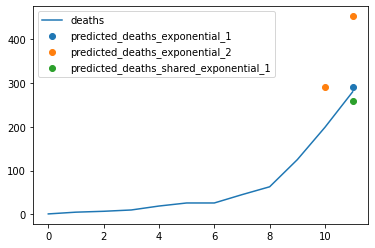

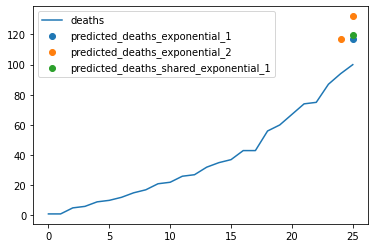

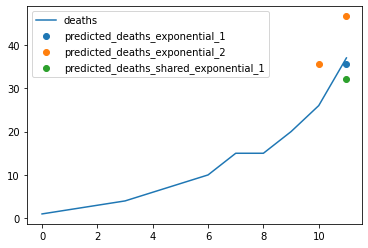

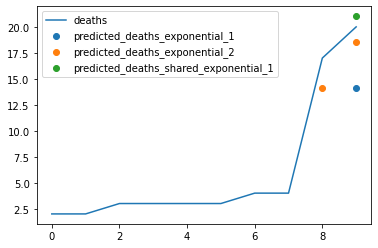

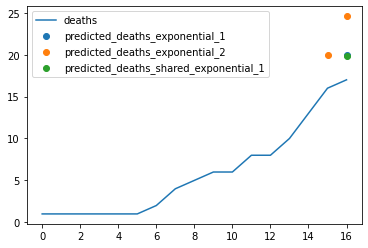

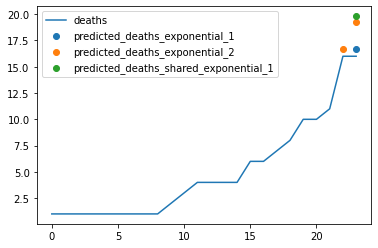

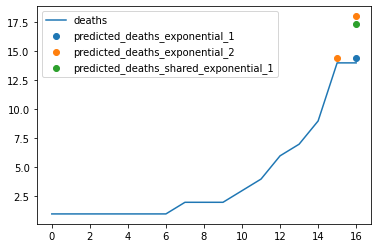

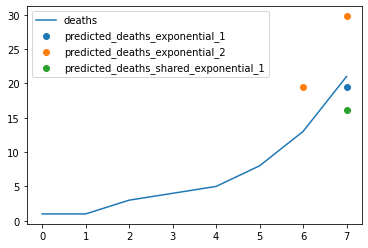

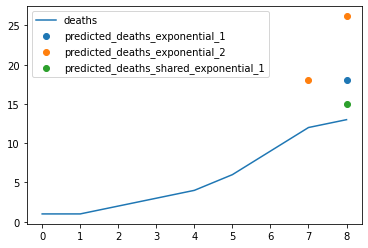

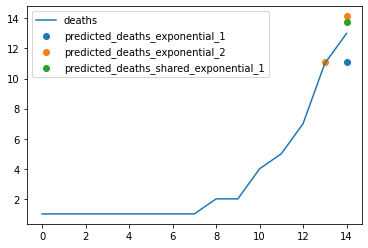

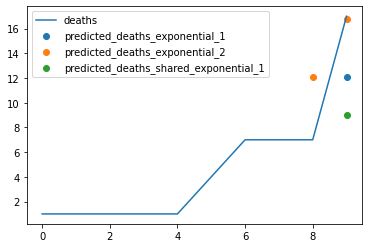

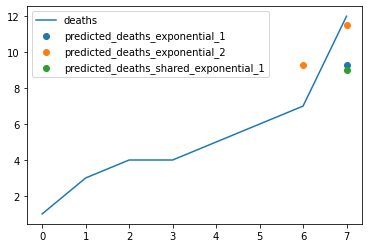

In [132]:
for i in range(len(test_df)):
    row = test_df.iloc[i]
    # If number of deaths greater than 10
    if max(row['deaths']) > 10:
        plot_prediction(row)

In [134]:
# # Flatten a list of lists
# flatten = lambda l: [item for sublist in l for item in sublist]

# def plot_log_dif(df,current_day_only=True,death_threshold = 5):
#     preds = list(df['predicted_deaths'])
#     outcomes = list(df['deaths'])
#     if current_day_only == True:
#         preds = [p[-1] for p in preds]
#         outcomes = [o[-1] for o in outcomes]
#     else:
#         preds = flatten(preds)
#         outcomes = flatten(outcomes)
        
#     filtered_preds = []
#     filtered_outcomes = []
#     for i in range(len(preds)):
#         if outcomes[i] > death_threshold:
#             filtered_preds.append(preds[i])
#             filtered_outcomes.append(outcomes[i])
        
#     plt.scatter([np.log(p) for p in preds], [np.log(o) for o in outcomes])
#     plt.plot([1.5, 5.5], [1.5, 5.5], ls="--", c=".3")
